### Importing the data

In [1]:
import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable('notebook')
medals = pd.read_excel("datasets/medals.xlsx")
gdp1 = pd.read_csv("datasets/gdp.csv")
gdp = pd.read_csv("datasets/gdp2.csv")
popTemp = pd.read_csv("datasets/population.csv")
iocCodes = pd.read_csv("datasets/iocCodes.csv")
isoCodes = pd.read_csv("datasets/isoCodes.csv")


### Making a DF with the isocodes and country names to combine different DFs together. Then we merge it with the countries of Europe so that we can use this as a filter.
## Watch out, the medals dataset uses IOC (NOC) encoding rather than alpha-3 (NED rather than NLD) 

In [2]:
iocCodes.columns = ['country','NOC','alpha-2']
countryCodes = pd.merge(isoCodes, iocCodes, on=['alpha-2'])
countryCodes = countryCodes[['country', 'NOC', 'alpha-2', 'alpha-3']]

europeDF = pd.DataFrame(['Albania','Andorra','Armenia','Austria','Azerbaijan','Belarus',
          'Belgium','Bosnia and Herzegovina','Bulgaria','Croatia','Cyprus',
          'Czechia','Czech Republic','Denmark','Estonia','Finland','France',
          'Georgia','Germany','Greece','Hungary','Iceland','Ireland','Italy',
          'Kosovo','Latvia','Liechtenstein','Lithuania','Luxembourg','Malta',
          'Moldova','Monaco','Montenegro','Netherlands','North Macedonia',
          'Macedonia','Norway','Poland','Portugal','Romania','Russia',
          'Russian Federation','San Marino','Serbia','Slovakia','Slovak Republic',
          'Slovenia','Spain','Sweden','Switzerland','Turkey','Ukraine',
          'United Kingdom','UK','Vatican City'])


europeDF.columns = ['country']

countryCodesFilter = pd.merge(europeDF, countryCodes, on='country')
# countryCodesFilter.head()

### population dataset

In [3]:
population = pd.merge(popTemp, countryCodesFilter, left_on='Country Name', right_on='country')

### medals per country per year


In [4]:
medalsPerCountryPerYear = medals.groupby(['NOC','Edition']).size().reset_index(name= 'medals')


### medals and population for 2008

In [5]:
meds2008 = medalsPerCountryPerYear.loc[medalsPerCountryPerYear['Edition']==2008][['NOC','medals']]


In [6]:
pop2008 = population[['country', '2008', 'NOC']]
pop2008.columns=['country', 'pop2018', 'NOC']
popMeds2008 = pd.merge(pop2008, meds2008, on=['NOC'])
popMeds2008.columns = ['country','population','NOC','medals']

In [7]:
popMeds2008 = pd.merge(popMeds2008, countryCodesFilter, on = 'country')

### make graph of population against medals for 2008

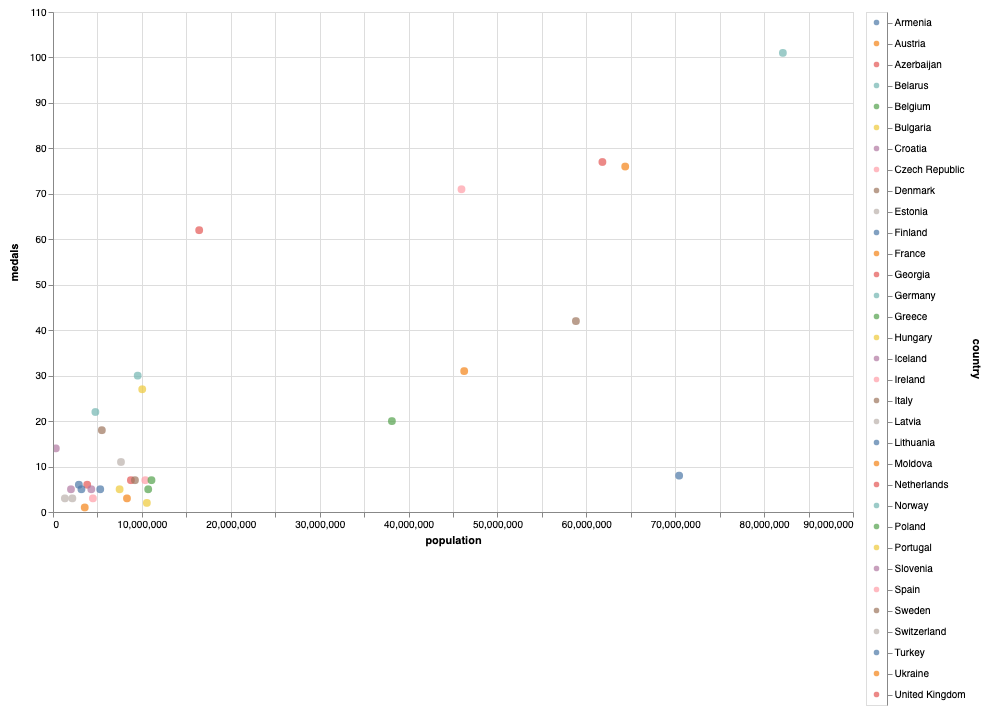

In [8]:
import altair as alt
import pandas as pd


selection = alt.selection_multi( fields=['country'])
color = alt.condition(selection,
                      alt.Color('country:N', legend=None),
                      alt.value('lightgray'))

points = alt.Chart(popMeds2008).mark_circle(size=60).encode(
    x='population:Q',
    y='medals:Q',
    color=color
)

text = points.mark_text(
    align='left',
    baseline='middle',
    dx=7
).add_selection(
    selection 
).properties(
    width=800, height=500
).interactive()

legend = alt.Chart(popMeds2008).mark_circle().encode(
    y=alt.Y('country:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)


chart = points + text | legend

chart

In [9]:
chart.save("temp/pop.html")



### Getting the medals per country and per type (gold, silver, bronze, total). This is directly saved to JSON which is used in the Javascript

In [10]:
medals_per_country = medals.groupby(['NOC']).size().reset_index(name='medals')
# medals_per_country.head()

In [12]:

medalsPerCountryPerType = medals.groupby(['NOC','Medal'], as_index=False).size()
medalsPerCountryPerType = medalsPerCountryPerType.unstack()#.transpose()


medalsPerCountryPerType = medalsPerCountryPerType.reset_index().fillna(0)
medalsPerCountryPerType = pd.merge(medals_per_country, medalsPerCountryPerType, on=['NOC'])



medalsPerCountryPerType = pd.merge(medalsPerCountryPerType, countryCodesFilter, on=['NOC'])
medalsPerCountryPerType = medalsPerCountryPerType.drop(['NOC'], axis = 1)

medalsPerCountryPerType.head()
medalsPerCountryPerType.to_json("temp/medalsPerCountryPerType.json", orient = 'records')


#### Want to see countries with most medals?

In [13]:
countriesWithMostMedals = medals_per_country.sort_values(by=['medals'], ascending = False).iloc[0:9]
countriesWithMostMedals.head()

,NOC,medals
130,USA,4335
128,URS,2049
43,GBR,1594
41,FRA,1314
62,ITA,1228


#### After europe filter:

In [14]:
countriesWithMostMedalsEurope = pd.merge(countriesWithMostMedals, countryCodesFilter, on='NOC')[['country','medals']]
countriesWithMostMedalsEurope.head()

,country,medals
0,United Kingdom,1594
1,France,1314
2,Italy,1228
3,Germany,1211
4,Hungary,1053


### Export medals_per_country to JSON

In [15]:
# medals_per_country.to_json("outputs/jsons/medalsPerCountry.json")


#### Simple bar chart of 10 countries with most medals

In [16]:
# import altair as alt
# alt.renderers.enable('notebook')

# alt.Chart(countriesWithMostMedals).mark_bar().encode(
#     x='number_medals:Q',
#     y=alt.Y(
#         'NOC:N',
#         sort=alt.EncodingSortField(
#             field="number_medals",  # The field to use for the sort
#             op= "values",  # The operation to run on the field prior to sorting
#             order="ascending"  # The order to sort in
#         )
#     )
# )


### Connect GDP with medals

In [17]:
gdp1.head()
gdpDF = gdp1.drop(['Country Name','Indicator Code','Indicator Name','Unnamed: 63'],axis = 1)
# gdpDF['Country Code'].unique()

#### I melt and sort the df so that the years become rows. I also merge it with the dataset of the medals just to remove the GDP values of countries that were no competing 

In [18]:
gdpMelted = pd.melt(gdpDF, id_vars=['Country Code'], var_name = 'Edition', value_name = 'GDP')
gdpMelted.columns = ['alpha-3','Edition','GDP']
gdpMelted['Edition'] = np.int64(gdpMelted['Edition'])
gdpMelted = pd.merge(gdpMelted, countryCodesFilter, on='alpha-3')[['NOC','Edition','GDP']]
# gdpMelted.head()
gdpMelted = pd.merge(medalsPerCountryPerYear,
                    gdpMelted, 
                    on=['NOC','Edition'])

gdpMelted = gdpMelted[['NOC','Edition','GDP']]

gdpPerCountryPerYear = gdpMelted.sort_values(['NOC','Edition']).reset_index().drop('index', axis = 1)

gdpPerCountryPerYear['NOC'].unique()


array(['ARM', 'AUT', 'AZE', 'BEL', 'BLR', 'BUL', 'CRO', 'CZE', 'DEN',
       'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GEO', 'GER', 'GRE', 'HUN',
       'IRL', 'ISL', 'ITA', 'LAT', 'LTU', 'MDA', 'MKD', 'NED', 'NOR',
       'POL', 'POR', 'RUS', 'SCG', 'SLO', 'SUI', 'SVK', 'SWE', 'TUR',
       'UKR'], dtype=object)

In [19]:
popMeds2008['NOC_x'].unique()

array(['ARM', 'AUT', 'AZE', 'BEL', 'BUL', 'BLR', 'SUI', 'CZE', 'GER',
       'DEN', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GEO', 'GRE', 'CRO',
       'HUN', 'IRL', 'ISL', 'ITA', 'LTU', 'LAT', 'MDA', 'NED', 'NOR',
       'POL', 'POR', 'SLO', 'SWE', 'TUR', 'UKR'], dtype=object)

In [20]:
medalsAndGdpPerCountryPerYear = pd.merge(gdpPerCountryPerYear,
                                         medalsPerCountryPerYear, 
                                        on=['Edition','NOC'])
# medalsAndGdpPerCountryPerYear.head()

In [21]:
medalsGDP2008 = medalsAndGdpPerCountryPerYear.loc[medalsAndGdpPerCountryPerYear['Edition'] == 2008]
medalsGDP2008Europe = pd.merge(medalsGDP2008, countryCodesFilter, on='NOC')[['country','GDP', 'medals']]
# medalsGDP2008Europe

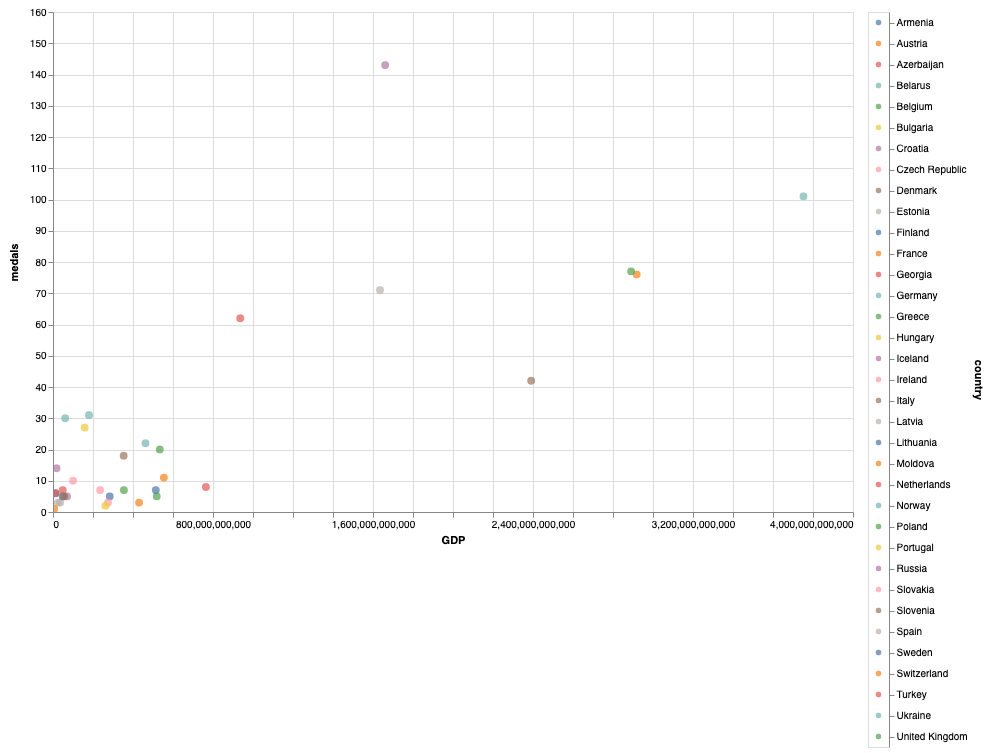

In [22]:
import altair as alt
import pandas as pd

selection = alt.selection_multi( fields=['country'])
color = alt.condition(selection,
                      alt.Color('country:N', legend=None),
                      alt.value('lightgray'))

points = alt.Chart(medalsGDP2008Europe).mark_circle(size=60).encode(
    x='GDP:Q',
    y='medals:Q',
    color=color
)

text = points.mark_text(
    align='left',
    baseline='middle',
    dx=7
).add_selection(
    selection 
).properties(
    width=800, height=500
).interactive()

legend = alt.Chart(medalsGDP2008Europe).mark_circle().encode(
    y=alt.Y('country:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)


chart = points + text | legend

chart

In [23]:
chart.save("temp/gdp.html")

In [24]:
medalsPopulationGDP = pd.merge(medalsGDP2008Europe, popMeds2008, on='country')[['country','GDP','population','medals_x']]
medalsPopulationGDP.columns = ['country','GDP','population','medals']
# medalsPopulationGDP.head()

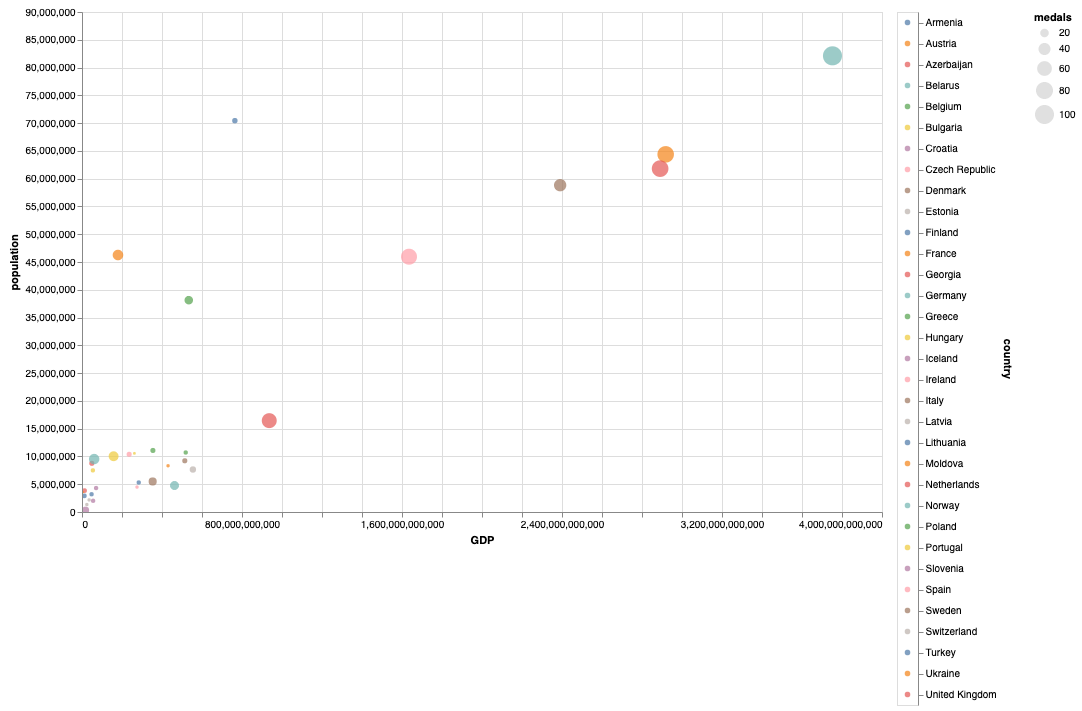

In [27]:
import altair as alt
import pandas as pd

selection = alt.selection_multi( fields=['country'])
color = alt.condition(selection,
                      alt.Color('country:N', legend=None),
                      alt.value('lightgray'))

points = alt.Chart(medalsPopulationGDP).mark_circle().encode(
    alt.X('GDP:Q',scale=alt.Scale(zero=False)),
    alt.Y('population:Q', scale=alt.Scale(zero=False, padding=1)),
#     x='GDP:Q',
#     y='population:Q',
    color=color, 
    size='medals:Q', 
    tooltip = ['country:N', 'medals:Q', 'GDP:Q', 'population:Q']
)

text = points.mark_text(
    align='left',
    baseline='middle',
    dx=7, 
    size = 0.1
).add_selection(
    selection 
).encode().properties(
    width=800, height=500
).interactive()

legend = alt.Chart(medalsPopulationGDP).mark_circle().encode(
    y=alt.Y('country:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)


# chart = points | legend
chart = points + text | legend

chart
# points

In [28]:
chart.save("temp/gdpPop.html")

In [46]:
medalsPerCountryPerYear['Edition'] = np.int64(medalsPerCountryPerYear['Edition'])
medalsPerCountryPerYearEurope = pd.merge(medalsPerCountryPerYear, countryCodesFilter, on='NOC')

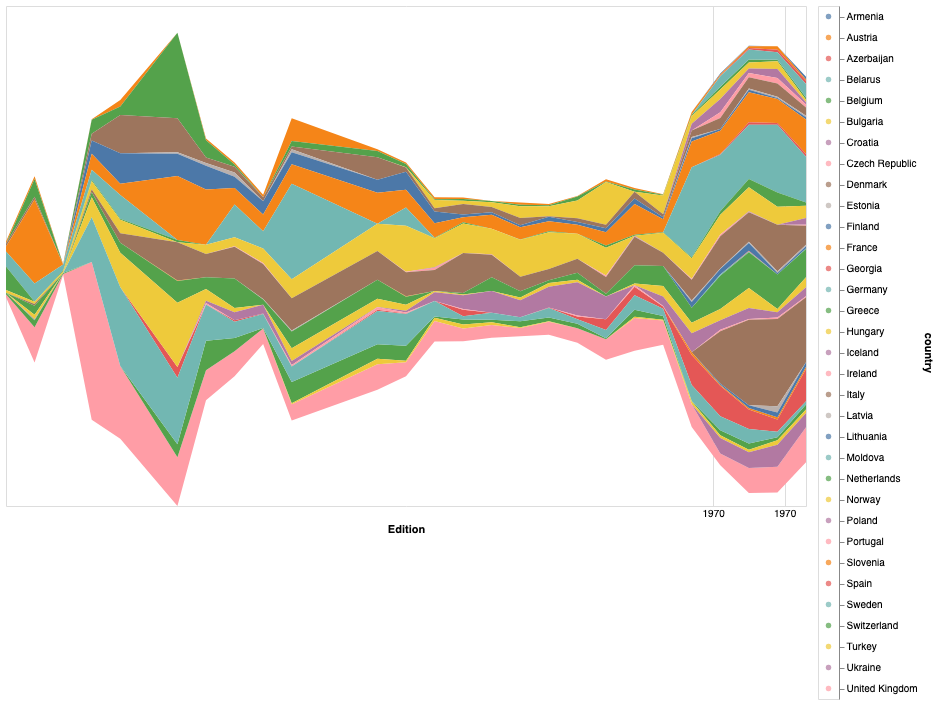

In [69]:
import altair as alt
from vega_datasets import data

selection = alt.selection_multi( fields=['country'])
# color = alt.condition(selection,
#                       alt.Color('country:N', legend=None,
#                                scale=alt.Scale(scheme='category20b')),
#                       alt.value('lightgray'))
color = alt.condition(selection,
                      alt.Color('country:N', legend=None),
                      alt.value('lightgray'))

area = alt.Chart(medalsPerCountryPerYearEurope).mark_area().encode(
    alt.X('Edition:T',
        axis=alt.Axis(format='%Y', domain=False, tickSize=0)
    ),
    alt.Y('medals:Q', stack='center', axis=None),
    color = color
    
).add_selection(
    selection
).properties(width = 800, height = 500).interactive()

legend = alt.Chart(medalsPopulationGDP).mark_circle().encode(
    y=alt.Y('country:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

chart = area | legend
chart

In [70]:
chart.save("temp/medalsPerYear.html")